# Simulation of Multi-Strain Viral Dynamics Using the Gillespie Algorithm

___

## Gellespie Algorithm:

To model the dynamics of a viral population, I used the Gillespie algorithm to make a stochastic simulation. It's useful in this case to use a stochastic model instead of a deterministic model because the stochastic model accounts for the inherent randomness and noise that naturally occurs in the system, due to each event having a separate probability. This is in contrast to a deterministic model, which does not account for individual events and uses a single function to model the entire system.


### Simulation Setup
To set up the simulation, I started with the master equation to base the stochastic model off of, dV/dt = pV - cV, where p is the growth rate, c is the decay rate, and v is the viral population. While the final goal was to model 4 viral populations, I started with modeling 1 to make sure the algorithm worked. I then use the basic outline of the gillespie algorithm, and broke it into psuedo code.

```python
Set initial conditions
While current time < final time
    calculate the growth and decay rate (propensities)
    randomly draw time until next event
    randomly draw next event 
    update the population
    update the time
return population & times
```
To choose the next time step, the program randomly selects a number from an exponential distribution with mean 1/total_propensity. I struggled quite bit with implementing how to choose the next event to occur. I first tried to randomly select a time from the weighted uniform distribution and then match to an event, but I kept running into issues. I changed my code to instead use np.random.choice with the propensities as the weights for 2 numbers. The negative numbers represent the decay events, and the positive numbers represent the growth events. I then used the absolute value of the number to find the index of the event to update the population. The program then updates the population and time, and repeats until the final time is reached. Note that after each tau jump, the program records the current population and time to be plotted later. 

To make the model work for multiple populations, I changed each of the initial conditions to be an array of 4 items, summed over all propensities, and changed the random event to be weighted over 8 numbers. I also decided to utilize numpy arrays so reduce the loops.



### Analysis

As expected, changing the growth and decay rates of each species had a significant impact on the final population dynamics. So much, in fact, that my initial integer rates had to be changed to floats within +/- .2 of each other to avoid immediate complete species takeover. There were a few key relationships that I found when setting different initial conditions and rates.

1. As expected, higher growth rates lead to higher populations, and higher decay rates lead to lower populations.
2. For a population with a smaller growth rate and larger initial population compared to the opposite, the population with the larger growth rate will eventually take over.
3. The inherent randomness of the system can lead to different outcomes even with the same initial conditions and rates, sometimes violating the above rules.
4. Once a population died out, it almost never came back. Anything other than a non-zero decay rate meant that the population couldn't recover.

### Conclusion

This model was really interesting to see how the stochasticity introduced so much variability to the results of the model, when compared to a deterministic model. While the deterministic is 'easier' computationally, I think that really highlights how important it is to use a stochastic model when the system is inherently noisy.

One thing to keep in mind, and the biggest limiting factor of this model for me is that it assumes homogenous populations. In reality, the populations wouldn't be homogenous. I imagine that introducing this into the model would slow the rates of growth and decay, as the populations would be more stable being surrounded by others of the same kind. However, I'm not sure if over-population would play into that and destabilize the populations!

Another limiting factor for this simulation is that I did not account for mutations. Mutations could and would impact the growth and decay rates of the populations, and lead to some drastically different outcomes. I think that would be a really interesting next step for this model.


### Algorithm

Winning Species: 0


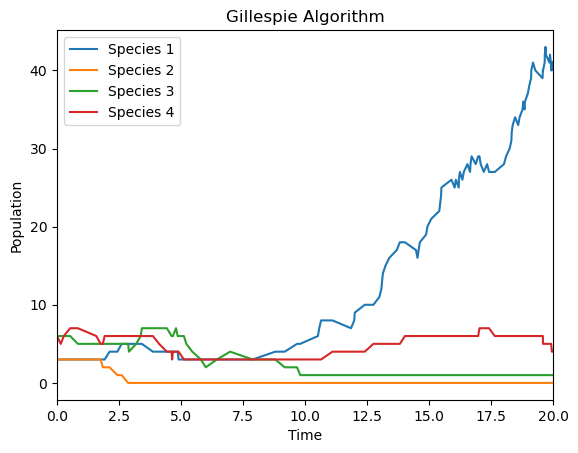

In [2]:
### Gillespie Algorithm ###
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches

'''

''' 

# Parameters
growth_rate = np.array([.3, .1, .1, .1])      # random growth rates
decay_rate = np.array([.1, .1, .3, .1])       # random decay rates
V = np.array([3, 3, 6, 6])                    # random initial population numbers
time_range = 20                     # total time alloted for run 

def gellispeAlg_fourSpecies (p, c, Tf, Vo):

    '''
    params:
        p: growth rate
        c: decay rate
        Tf: total time
        Vo: initial population
    '''

    # Initialize time and population
    total_time = 0
    V = Vo
    output_data = []
    time_array = [0]

    # Add initial population to output data
    output_data.append(([V[0], V[1], V[2], V[3]]))

    # Algorithm Loop
    while total_time <= Tf:

        # Calculate growth and decay rates for each species
        growth = np.multiply(p, V)  # -> array of propensites for growth
        decay = np.multiply(c, V)   # -> array of propensities for decay
        all_events = (np.append(growth, decay)) / np.sum(np.append(growth, decay))

        if np.isnan(all_events).any():
            break

        # Calculate total event time
        total_propensity = np.sum(growth) + np.sum(decay)  
        # print(total_propensity)  

        # Draw from exponential dist for time to move fowards
        time_step = np.random.exponential(1/total_propensity)
        # print(time_step)

        # Draw from weighted uniform distribution to select event
        event_number = np.random.choice([1, 2, 3, 4, -1, -2, -3, -4], 1, p = all_events)
        
        # Update population
        if event_number < 0:            # Decay event
                V[abs(event_number) - 1] -= 1
        else:                           # Growth event
            V[event_number - 1] += 1
        
        # Update time
        total_time += time_step
        time_array.append(total_time)

        # Update Output
        output_data.append(([V[0], V[1], V[2], V[3]]))


    winningSpecies = np.argmax(output_data[-1])
    
    return output_data, time_array, winningSpecies

# Run Algorithm
output, time, bestSpec  = gellispeAlg_fourSpecies(growth_rate, decay_rate, time_range, V)

print('Winning Species:', bestSpec)

# Plot Data
plt.plot(time, output)
plt.xlim(0, 20)
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Gillespie Algorithm')

# Legend
plt.legend(['Species 1', 'Species 2', 'Species 3', 'Species 4'])


## 50 Simulations

/var/folders/kv/wsxn0wsx5_l19spz88tqtfd00000gn/T/ipykernel_23523/814861967.py:41: RuntimeWarning: invalid value encountered in divide
  all_events = (np.append(growth, decay)) / np.sum(np.append(growth, decay))


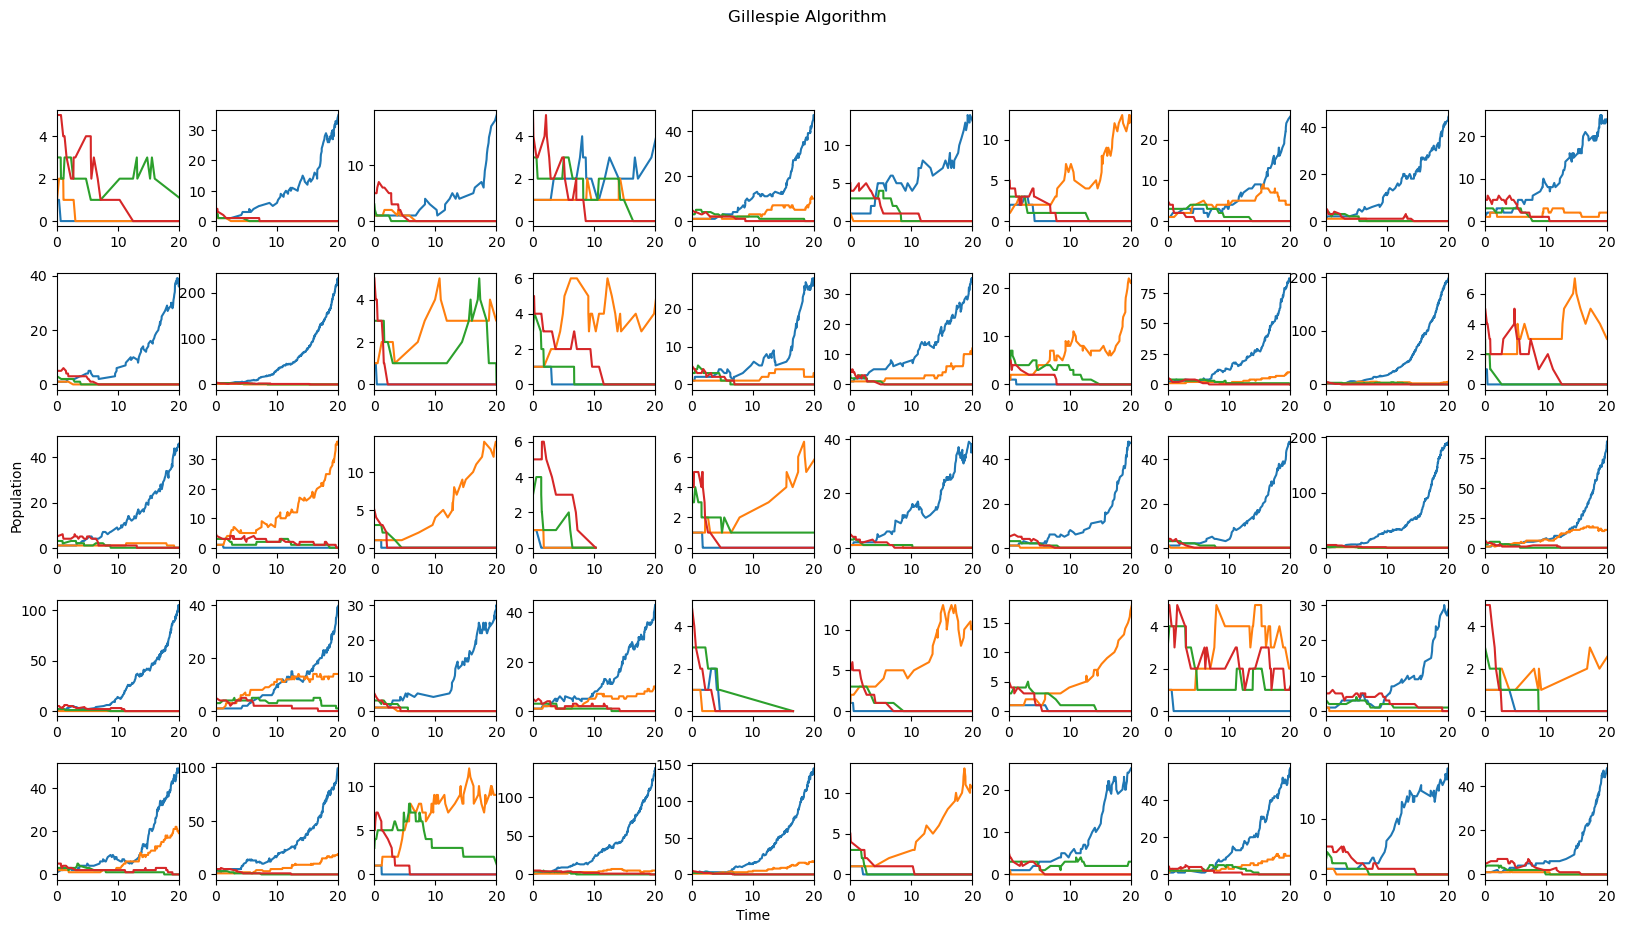

In [3]:

# Multiple Plots
fig, axes = plt.subplots(5,10, figsize=(20, 10))
fig.subplots_adjust(hspace = .4, wspace=.3)
fig.suptitle('Gillespie Algorithm')
axes[2, 0].set_ylabel('Population')
axes[4, 4].set_xlabel('Time')


speciesCount = []

# Loop through axes
for i, ax in enumerate(axes.flat):

    # Parameters
    growth_rate = np.array([.3, .2, .1, .1])      # random growth rates
    decay_rate = np.array([.1, .1, .2, .3])       # random decay rates
    V = np.array([1, 1, 3, 5])                    # random initial population numbers
    time_range = 20                     # total time alloted for run 

    # Remove ticks
    ax.set_xlim(0, 20)

    # Run Algorithm
    output, time, best = gellispeAlg_fourSpecies(growth_rate, decay_rate, 20, V)

    # Record Winning Species
    speciesCount.append(best)

    # Plot Data
    ax.plot(time, output)

## 50 Simulation Results

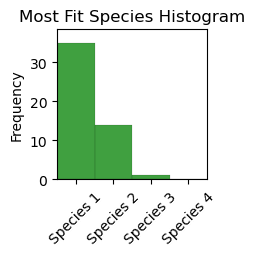

In [4]:

# Histogram
figWidth = 8.5
figHeight = 11
plt.figure(figsize=(figWidth,figHeight))
panelWidth=1.5
panelHeight=1.5
panel1=plt.axes([4/figWidth,5/figHeight,panelWidth/figWidth,panelHeight/figHeight])

bins = np.arange(0,5,1)
xHisto, bins = np.histogram(speciesCount, bins=bins)

panel1.set_xlim(0,4)
panel1.set_ylim(0,max(xHisto) * 1.1)    # Change two vales to flip graph
panel1.set_ylabel('Frequency')

panel1.set_xticks([.5, 1.5, 2.5, 3.5])
panel1.set_xticklabels(['Species 1', 'Species 2', 'Species 3', 'Species 4'], rotation=45)

plt.title('Most Fit Species Histogram')

for i in range(0,len(xHisto),1):
    left = bins[i]
    bottom = 0
    width = bins[i+1] - left        # bins list is one longer than x-histo list
    height = xHisto[i]
    panel1.add_patch(mplpatches.Rectangle((left,bottom),width,height,
                                          facecolor='green',
                                          edgecolor='black',
                                          linewidth=0.1,
                                          alpha=.75))
